In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm

from astropy.io import fits
import fitsio

In [2]:
import lightkurve as lk
from scipy import stats
from astropy.time import Time
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.visualization import simple_norm

In [3]:
from roman_lcs import Machine, RomanMachine

In [4]:
PATH = "/Users/jimartin/Work/ROMAN/simulations/run_v0.2"

In [5]:
ff = sorted(os.listdir(f"{PATH}/imgs"))
ff = [f"{PATH}/imgs/{x}" for x in ff]
len(ff)

6702

In [6]:
ff[:2]

['/Users/jimartin/Work/ROMAN/simulations/run_v0.2/imgs/rimtimsim_WFI_rampfitted_F146_SCA01_field01_ramp_subframe_0250x0250_20270214T0013_sim.fits',
 '/Users/jimartin/Work/ROMAN/simulations/run_v0.2/imgs/rimtimsim_WFI_rampfitted_F146_SCA01_field01_ramp_subframe_0250x0250_20270214T0025_sim.fits']

In [7]:
catalog = pd.read_csv(f"{PATH}/mean_input_catalog.txt", index_col=0)
catalog["flux"] = 10 ** ((27.53861667037689 - catalog["F146"])/2.5)
catalog["flux_err"] = np.sqrt(catalog["flux"])
catalog

,sicbroid,xcol,ycol,F146,ra_deg,dec_deg,flux,flux_err
-1,0,125.000000,125.000000,17.000,268.279268,-28.746497,16422.779737,128.151394
0,1,175.281640,217.529604,20.717,268.282355,-28.744864,535.360923,23.137868
1,2,69.039869,140.004071,24.701,268.277838,-28.745248,13.647298,3.694225
2,3,24.095405,52.197116,23.149,268.274992,-28.746840,56.996301,7.549589
3,4,151.019019,217.089188,23.617,268.281617,-28.744503,37.037927,6.085879
...,...,...,...,...,...,...,...,...
18545,18546,49.219505,94.403485,24.868,268.276466,-28.746129,11.701638,3.420766
18546,18547,2.039745,110.334565,25.123,268.275317,-28.744991,9.252235,3.041749
18547,18548,91.446810,21.156735,24.298,268.276492,-28.748681,19.780928,4.447576
18548,18549,194.216412,91.312406,23.769,268.280779,-28.748435,32.199318,5.674444


In [9]:
sources = catalog.query("F146 < 20")
sources = sources.rename(columns={"ra_deg": "ra", "dec_deg": "dec", "xcol": "column", "ycol": "row"})
sources

,sicbroid,column,row,F146,ra,dec,flux,flux_err
-1,0,125.000000,125.000000,17.000,268.279268,-28.746497,16422.779737,128.151394
4,5,208.192458,79.438460,19.243,268.280998,-28.748958,2080.878237,45.616644
125,126,26.668413,73.090598,19.524,268.275425,-28.746337,1606.374007,40.079596
143,144,198.335185,62.707689,19.911,268.280417,-28.749241,1124.725828,33.536932
153,154,140.963853,70.147182,17.074,268.278816,-28.748168,15340.752671,123.857792
...,...,...,...,...,...,...,...,...
18458,18459,167.396424,209.963595,19.445,268.281989,-28.744940,1727.613815,41.564574
18461,18462,178.759984,115.323406,19.176,268.280722,-28.747574,2213.332536,47.046068
18481,18482,126.902694,152.644854,15.671,268.279795,-28.745808,55853.020971,236.332437
18506,18507,10.192706,91.303237,19.849,268.275238,-28.745611,1190.821503,34.508282


# PSFMachine

In [12]:
mac = RomanMachine.from_file(
    ff[:100], 
    sources=sources,
    sparse_dist_lim=2, 
    sources_flux_column="flux"
)
mac

Creating delta arrays: 100%|███████████████████████████████████████████████████████████████| 727/727 [00:00<00:00, 2484.37it/s]


RomanMachine (N sources, N times, N pixels): (727, 100, 62500)

In [23]:
mac._get_source_mask()

TypeError: Machine._get_source_mask() got an unexpected keyword argument 'upper_radius_limit'

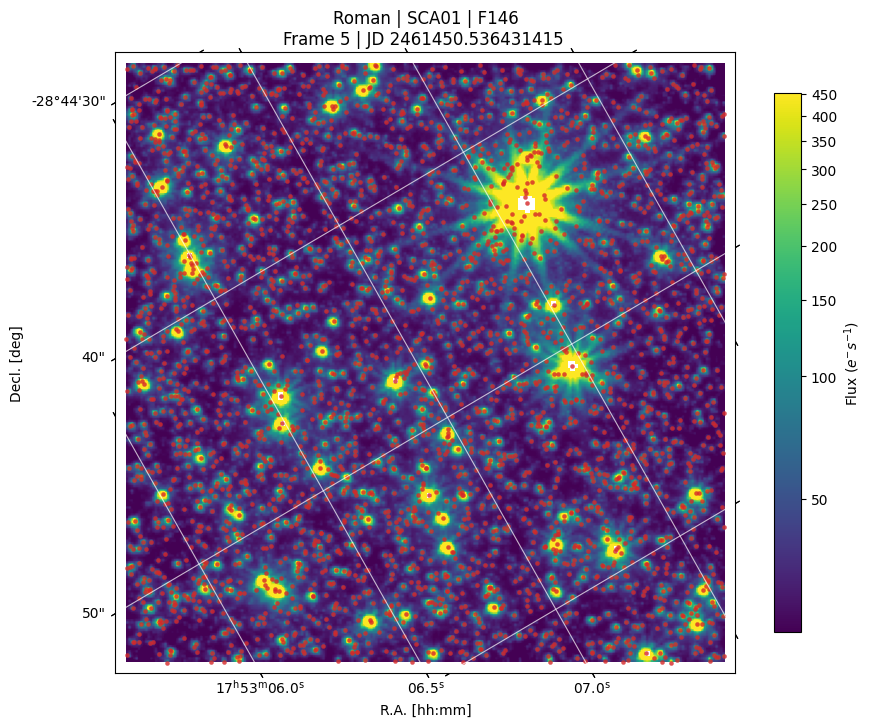

In [181]:
mac.plot_image(sources=True, frame_index=5);

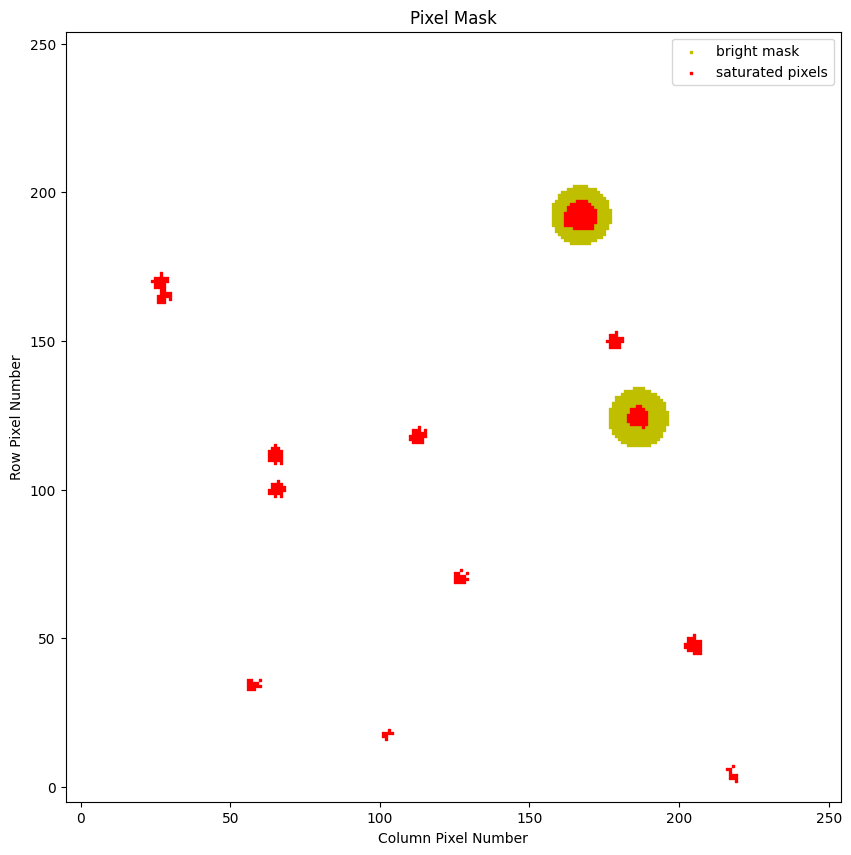

In [182]:
mac._mask_pixels(magnitude_bright_limit=13)
_ = mac.plot_pixel_masks()

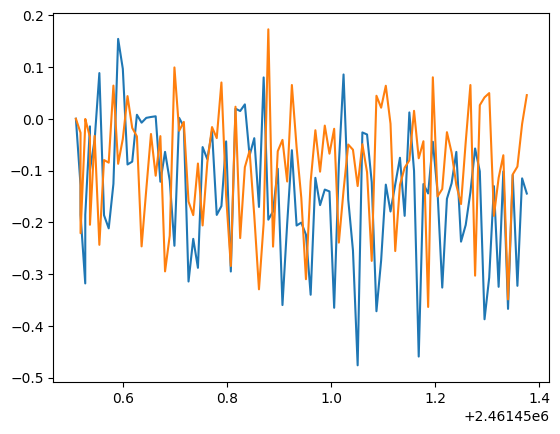

In [183]:
mac._pointing_offset()

plt.plot(mac.time, mac.ra_offset*3600);
plt.plot(mac.time, mac.dec_offset*3600);

/Users/jimartin/Work/ROMAN/Roman-lcs/src/roman_lcs/machine.py:373: RuntimeWarning: All-NaN slice encountered
  max_flux = np.nanmax(self.flux[self.time_mask], axis=0)


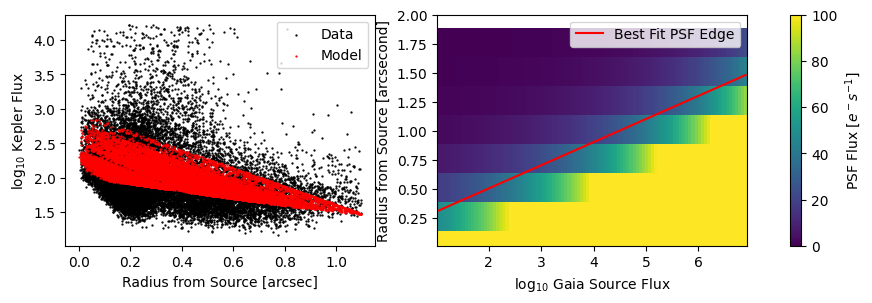

In [171]:
upper_radius_limit = 2.
lower_radius_limit = 0.01
upper_flux_limit = 1e5
lower_flux_limit = 50

mac._get_source_mask(
    upper_radius_limit=upper_radius_limit,
    lower_radius_limit=lower_radius_limit,
    upper_flux_limit=upper_flux_limit,
    lower_flux_limit=lower_flux_limit,
    plot=True
)

In [172]:
mac.source_mask, mac.uncontaminated_source_mask

(<Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 216608 stored elements and shape (1698, 62500)>,
 <Compressed Sparse Row sparse matrix of dtype 'bool'
 	with 7225 stored elements and shape (1698, 62500)>)

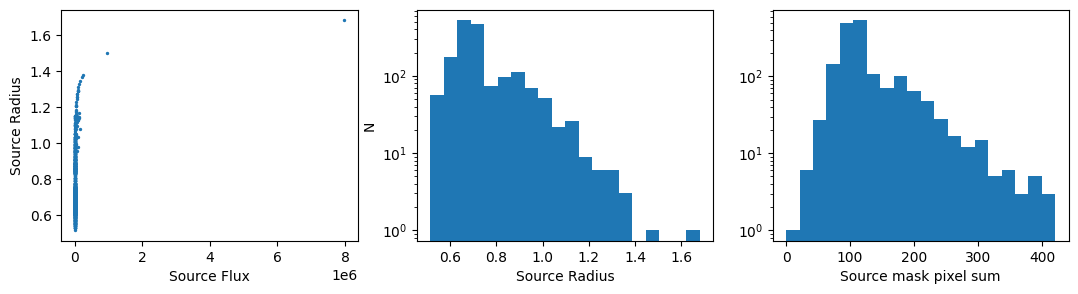

In [173]:
fig, ax = plt.subplots(1, 3, figsize=(13, 3))

ax[0].scatter(mac.sources.flux, mac.radius, s=2)
ax[0].set_xlabel("Source Flux")
ax[0].set_ylabel("Source Radius")

ax[1].hist(mac.radius, bins=20)
ax[1].set_xlabel("Source Radius")
ax[1].set_ylabel("N")
ax[1].set_yscale("log")

ax[2].hist(np.array(mac.source_mask.sum(axis=1)).ravel(), bins=20)
ax[2].set_xlabel("Source mask pixel sum")
ax[2].set_yscale("log")

plt.show()

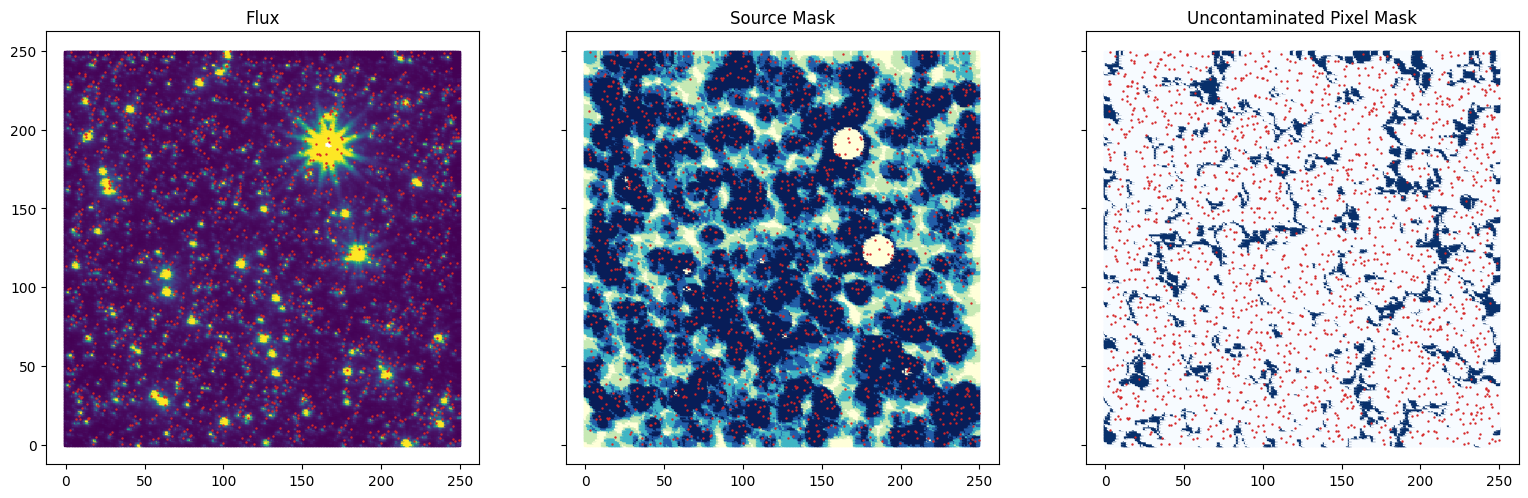

In [174]:
fig, ax = plt.subplots(1, 3, figsize=(19, 7), sharex=True, sharey=True)

ax[0].set_title("Flux")
ax[0].scatter(
    mac.column,
    mac.row,
    c=mac.flux[0], 
    vmin=10, 
    vmax=500,
    s=5,
    marker="s",
)
ax[0].scatter(mac.sources.column, mac.sources.row, c="tab:red", marker=".", s=2)

ax[1].set_title("Source Mask")
ax[1].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=4,
    alpha=1,
    cmap="YlGnBu",
    s=5,
    marker="s",
)
ax[1].scatter(mac.sources.column, mac.sources.row, c="tab:red", marker=".", s=2)

ax[2].set_title("Uncontaminated Pixel Mask")
ax[2].scatter(
    mac.column,
    mac.row,
    c=np.array(mac.uncontaminated_source_mask.sum(axis=0)[0]), 
    vmin=0, 
    vmax=1,
    alpha=1,
    cmap="Blues",
    s=5,
    marker="s",
)
ax[2].scatter(mac.sources.column, mac.sources.row, c="tab:red", marker=".", s=2)

ax[0].set_aspect("equal", adjustable="box")
ax[1].set_aspect("equal", adjustable="box")
ax[2].set_aspect("equal", adjustable="box")

plt.show()

In [167]:
mac.meta

{'MISSION': 'Roman',
 'TELESCOP': 'Roman',
 'RADESYS': 'FK5',
 'EQUINOX': 2000.0,
 'FILTER': 'F146',
 'DETECTOR': 'SCA01',
 'EXPOSURE': 57.0,
 'READMODE': 'ramp'}

/Users/jimartin/Work/ROMAN/Roman-lcs/src/roman_lcs/machine.py:373: RuntimeWarning: All-NaN slice encountered
  max_flux = np.nanmax(self.flux[self.time_mask], axis=0)
/Users/jimartin/miniforge3/envs/roman/lib/python3.10/site-packages/scipy/sparse/_index.py:151: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray(i, j, x)


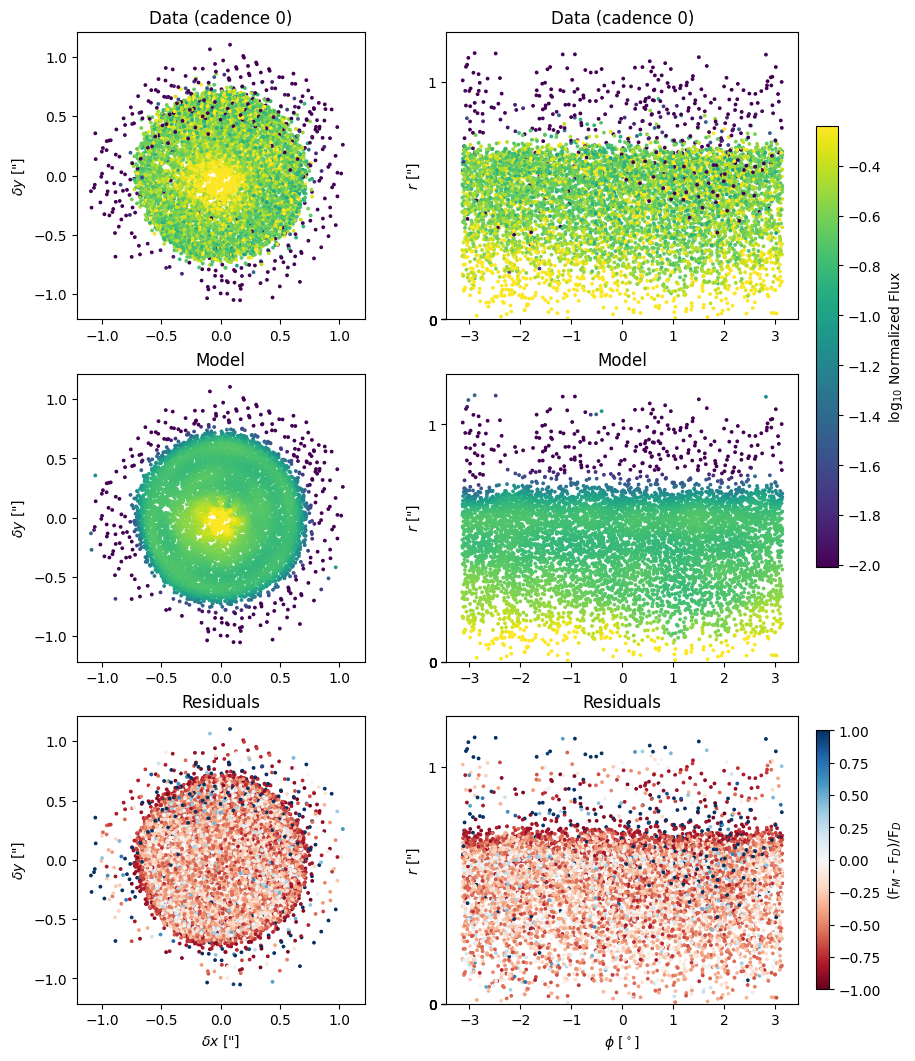

In [168]:
mac.rmin = 0.02
mac.rmax = 0.8
mac.cut_r = 0.15
mac.n_r_knots = 9
mac.n_phi_knots = 15

upper_radius_limit = 2.
lower_radius_limit = 0.01
upper_flux_limit = 1e5
lower_flux_limit = 50

mac.build_shape_model(
    frame_index=0, 
    flux_cut_off=0.1, 
    upper_radius_limit=upper_radius_limit,
    lower_radius_limit=lower_radius_limit,
    upper_flux_limit=upper_flux_limit,
    lower_flux_limit=lower_flux_limit,
    correct_centroid_offset=False,
    plot=True);